In [0]:
!pip install jsonlines

In [0]:
import os
import json
import jsonlines
import numpy as np
from collections import defaultdict

import torch
import torch.nn as nn
from torch.nn import RNNCell
from torch.nn import RNNBase, RNN
from torch.utils.data import Dataset, DataLoader
from torch.nn import Embedding
import torch.optim as optim
from tqdm import tqdm
import sys
import pickle as pkl
import matplotlib.pyplot as plt
import random
import math

In [0]:
def load_wikitext(filename='wikitext2-sentencized.json'):
    if not os.path.exists(filename):
        !wget "https://nyu.box.com/shared/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json" -O $filename
    
    datasets = json.load(open(filename, 'r'))
    for name in datasets:
        datasets[name] = [x.split() for x in datasets[name]]
    vocab = list(set([t for ts in datasets['train'] for t in ts]))      
    print("Vocab size: %d" % (len(vocab)))
    return datasets, vocab

def perplexity(model, sequences):
    n_total = 0
    logp_total = 0
    for sequence in sequences:
        logp_total += model.sequence_logp(sequence)
        n_total += len(sequence) + 1  
    ppl = 2 ** (- (1.0 / n_total) * logp_total)  
    return ppl
  
datasets, vocab = load_wikitext()

Vocab size: 33175


# DS-GA 1011 Homework 2
## N-Gram and Neural Language Modeling

## I. N-Gram Language Modeling

### Additive Smoothing

In [0]:
class NGramAdditive(object):
    def __init__(self, n, delta, vsize):
        self.n = n
        self.delta = delta
        self.count = defaultdict(lambda: defaultdict(float))
        self.total = defaultdict(float)
        self.vsize = vsize
    
    def estimate(self, sequences):
        for sequence in sequences:
            padded_sequence = ['<bos>']*(self.n-1) + sequence + ['<eos>']
            for i in range(len(padded_sequence) - self.n+1):
                ngram = tuple(padded_sequence[i:i+self.n])
                prefix, word = ngram[:-1], ngram[-1]
                self.count[prefix][word] += 1
                self.total[prefix] += 1
                
    def sequence_logp(self, sequence):
        padded_sequence = ['<bos>']*(self.n-1) + sequence + ['<eos>']
        total_logp = 0
        for i in range(len(padded_sequence) - self.n+1):
            ngram = tuple(padded_sequence[i:i+self.n])
            total_logp += np.log2(self.ngram_prob(ngram))
        return total_logp

    def ngram_prob(self, ngram):
        prefix = ngram[:-1]
        word = ngram[-1]
        prob = ((self.delta + self.count[prefix][word]) / 
                (self.total[prefix] + self.delta*self.vsize))
        return prob

In [0]:
delta = 0.0005
for n in [2, 3, 4]:
    lm = NGramAdditive(n=n, delta=delta, vsize=len(vocab)+1)  # +1 is for <eos>
    lm.estimate(datasets['train'])

    print("Baseline (Additive smoothing, n=%d, delta=%.4f)) Train Perplexity: %.3f" % (n, delta, perplexity(lm, datasets['train'])))
    print("Baseline (Additive smoothing, n=%d, delta=%.4f)) Valid Perplexity: %.3f" % (n, delta, perplexity(lm, datasets['valid'])))

Vocab size: 33175
Baseline (Additive smoothing, n=2, delta=0.0005)) Train Perplexity: 90.228
Baseline (Additive smoothing, n=2, delta=0.0005)) Valid Perplexity: 525.825
Baseline (Additive smoothing, n=3, delta=0.0005)) Train Perplexity: 26.768
Baseline (Additive smoothing, n=3, delta=0.0005)) Valid Perplexity: 2577.128
Baseline (Additive smoothing, n=4, delta=0.0005)) Train Perplexity: 19.947
Baseline (Additive smoothing, n=4, delta=0.0005)) Valid Perplexity: 9570.901


### I.1 Interpolation

In [0]:
class NGramInterpolation(object):
    def __init__(self, lambda_ls, vsize):
        self.l = lambda_ls
        self.count = defaultdict(lambda: defaultdict(float))
        self.total = defaultdict(float)
        self.vsize = vsize
    
    def estimate(self, sequences):
        for n in range(1, len(self.l)):
            for sequence in sequences:
                padded_sequence = ['<bos>']*(n-1) + sequence + ['<eos>']
                for i in range(len(padded_sequence) - n+1):
                    ngram = tuple(padded_sequence[i:i+n])
                    prefix, word = ngram[:-1], ngram[-1]
                    self.count[prefix][word] += 1
                    self.total[prefix] += 1
                
    def sequence_logp(self, sequence):
        n = len(self.l)
        padded_sequence = ['<bos>']*(n-1) + sequence + ['<eos>']
        total_logp = 0
        for i in range(len(padded_sequence) - n):
            ngram = tuple(padded_sequence[i:i+n])
            total_logp += np.log2(self.ngram_prob(ngram))
        return total_logp



    def ngram_prob(self, ngram):
        prob = self.l[0]/self.vsize
        for n in range(1, len(self.l)):
            prefix = ngram[-n:-1]
            word = ngram[-1]
            if self.total[prefix] != 0:
                prob += self.l[n] * self.count[prefix][word] / self.total[prefix]
        return prob

#### Tune $\lambda$ for n=2

In [0]:
lambda_range = [[0.33, 0.33, 0.34], [0.2, 0.3, 0.5], 
                [0.2, 0.8, 0], [0.2, 0, 0.8],
                [0.1, 0.1, 0.8]]
for l in lambda_range:
    lm = NGramInterpolation(lambda_ls=l, vsize=len(vocab)+1)
    lm.estimate(datasets['train'])

    print("Interpolation smoothing, n=%d, lambda=%s, Train Perplexity: %.3f" % (len(l)-1, l, perplexity(lm, datasets['train'])))
    print("Interpolation smoothing, n=%d, lambda=%s, Valid Perplexity: %.3f" % (len(l)-1, l, perplexity(lm, datasets['valid'])))
    print()

Interpolation smoothing, n=2, lambda=[0.33, 0.33, 0.34], Train Perplexity: 167.716
Interpolation smoothing, n=2, lambda=[0.33, 0.33, 0.34], Valid Perplexity: 370.320

Interpolation smoothing, n=2, lambda=[0.2, 0.3, 0.5], Train Perplexity: 126.119
Interpolation smoothing, n=2, lambda=[0.2, 0.3, 0.5], Valid Perplexity: 316.744

Interpolation smoothing, n=2, lambda=[0.2, 0.8, 0], Train Perplexity: 1060.071
Interpolation smoothing, n=2, lambda=[0.2, 0.8, 0], Valid Perplexity: 907.352

Interpolation smoothing, n=2, lambda=[0.2, 0, 0.8], Train Perplexity: 92.656
Interpolation smoothing, n=2, lambda=[0.2, 0, 0.8], Valid Perplexity: 420.348

Interpolation smoothing, n=2, lambda=[0.1, 0.1, 0.8], Train Perplexity: 90.183
Interpolation smoothing, n=2, lambda=[0.1, 0.1, 0.8], Valid Perplexity: 307.340



In [0]:
lambda_range = [[0.1, 0.2, 0.7], [0.1, 0.3, 0.6],
                [0.01, 0.29, 0.7], [0.01, 0.2, 0.79]]
for l in lambda_range:
    lm = NGramInterpolation(lambda_ls=l, vsize=len(vocab)+1)
    lm.estimate(datasets['train'])

    print("Interpolation smoothing, n=%d, lambda=%s, Train Perplexity: %.3f" % (len(l)-1, l, perplexity(lm, datasets['train'])))
    print("Interpolation smoothing, n=%d, lambda=%s, Valid Perplexity: %.3f" % (len(l)-1, l, perplexity(lm, datasets['valid'])))
    print()

Interpolation smoothing, n=2, lambda=[0.1, 0.2, 0.7], Train Perplexity: 98.576
Interpolation smoothing, n=2, lambda=[0.1, 0.2, 0.7], Valid Perplexity: 295.600

Interpolation smoothing, n=2, lambda=[0.1, 0.3, 0.6], Train Perplexity: 109.225
Interpolation smoothing, n=2, lambda=[0.1, 0.3, 0.6], Valid Perplexity: 297.180

Interpolation smoothing, n=2, lambda=[0.01, 0.29, 0.7], Train Perplexity: 96.745
Interpolation smoothing, n=2, lambda=[0.01, 0.29, 0.7], Valid Perplexity: 294.042

Interpolation smoothing, n=2, lambda=[0.01, 0.2, 0.79], Train Perplexity: 89.199
Interpolation smoothing, n=2, lambda=[0.01, 0.2, 0.79], Valid Perplexity: 300.005



Best setting: [0.01, 0.29, 0.7]

Lowest Valid Perplexity: 294.042

#### Tune $\lambda$ for n=3

In [0]:
lambda_range = [[0.01, 0.29, 0.3, 0.4], [0.01, 0.29, 0.2, 0.5],
                [0.01, 0.19, 0.3, 0.5], [0.01, 0.19, 0.2, 0.6]]
for l in lambda_range:
    lm = NGramInterpolation(lambda_ls=l, vsize=len(vocab)+1)
    lm.estimate(datasets['train'])

    print("Interpolation smoothing, n=%d, lambda=%s, Train Perplexity: %.3f" % (len(l)-1, l, perplexity(lm, datasets['train'])))
    print("Interpolation smoothing, n=%d, lambda=%s, Valid Perplexity: %.3f" % (len(l)-1, l, perplexity(lm, datasets['valid'])))
    print()

Interpolation smoothing, n=3, lambda=[0.01, 0.29, 0.3, 0.4], Train Perplexity: 15.325
Interpolation smoothing, n=3, lambda=[0.01, 0.29, 0.3, 0.4], Valid Perplexity: 293.228

Interpolation smoothing, n=3, lambda=[0.01, 0.29, 0.2, 0.5], Train Perplexity: 13.462
Interpolation smoothing, n=3, lambda=[0.01, 0.29, 0.2, 0.5], Valid Perplexity: 318.350

Interpolation smoothing, n=3, lambda=[0.01, 0.19, 0.3, 0.5], Train Perplexity: 12.978
Interpolation smoothing, n=3, lambda=[0.01, 0.19, 0.3, 0.5], Valid Perplexity: 313.347

Interpolation smoothing, n=3, lambda=[0.01, 0.19, 0.2, 0.6], Train Perplexity: 11.655
Interpolation smoothing, n=3, lambda=[0.01, 0.19, 0.2, 0.6], Valid Perplexity: 344.486



In [0]:
lambda_range = [[0.01, 0.29, 0.4, 0.3], [0.01, 0.29, 0.5, 0.2],
                [0.01, 0.19, 0.5, 0.3], [0.01, 0.19, 0.6, 0.2]]
for l in lambda_range:
    lm = NGramInterpolation(lambda_ls=l, vsize=len(vocab)+1)
    lm.estimate(datasets['train'])

    print("Interpolation smoothing, n=%d, lambda=%s, Train Perplexity: %.3f" % (len(l)-1, l, perplexity(lm, datasets['train'])))
    print("Interpolation smoothing, n=%d, lambda=%s, Valid Perplexity: %.3f" % (len(l)-1, l, perplexity(lm, datasets['valid'])))
    print()

Interpolation smoothing, n=3, lambda=[0.01, 0.29, 0.4, 0.3], Train Perplexity: 17.985
Interpolation smoothing, n=3, lambda=[0.01, 0.29, 0.4, 0.3], Valid Perplexity: 278.743

Interpolation smoothing, n=3, lambda=[0.01, 0.29, 0.5, 0.2], Train Perplexity: 22.212
Interpolation smoothing, n=3, lambda=[0.01, 0.29, 0.5, 0.2], Valid Perplexity: 271.353

Interpolation smoothing, n=3, lambda=[0.01, 0.19, 0.5, 0.3], Train Perplexity: 17.256
Interpolation smoothing, n=3, lambda=[0.01, 0.19, 0.5, 0.3], Valid Perplexity: 283.224

Interpolation smoothing, n=3, lambda=[0.01, 0.19, 0.6, 0.2], Train Perplexity: 21.223
Interpolation smoothing, n=3, lambda=[0.01, 0.19, 0.6, 0.2], Valid Perplexity: 277.553



Best setting: [0.01, 0.29, 0.5, 0.2]

Lowest Valid Perplexity: 271.353

#### Tune $\lambda$ for n=4

In [0]:
lambda_range = [[0.01, 0.29, 0.5, 0.1, 0.1], [0.01, 0.29, 0.4, 0.2, 0.1],
                [0.01, 0.19, 0.5, 0.2, 0.1]]
for l in lambda_range:
    lm = NGramInterpolation(lambda_ls=l, vsize=len(vocab)+1)
    lm.estimate(datasets['train'])

    print("Interpolation smoothing, n=%d, lambda=%s, Train Perplexity: %.3f" % (len(l)-1, l, perplexity(lm, datasets['train'])))
    print("Interpolation smoothing, n=%d, lambda=%s, Valid Perplexity: %.3f" % (len(l)-1, l, perplexity(lm, datasets['valid'])))
    print()

Interpolation smoothing, n=4, lambda=[0.01, 0.29, 0.5, 0.1, 0.1], Train Perplexity: 10.469
Interpolation smoothing, n=4, lambda=[0.01, 0.29, 0.5, 0.1, 0.1], Valid Perplexity: 277.409

Interpolation smoothing, n=4, lambda=[0.01, 0.29, 0.4, 0.2, 0.1], Train Perplexity: 9.083
Interpolation smoothing, n=4, lambda=[0.01, 0.29, 0.4, 0.2, 0.1], Valid Perplexity: 282.617

Interpolation smoothing, n=4, lambda=[0.01, 0.19, 0.5, 0.2, 0.1], Train Perplexity: 8.805
Interpolation smoothing, n=4, lambda=[0.01, 0.19, 0.5, 0.2, 0.1], Valid Perplexity: 286.733



In [0]:
lambda_range = [[0.01, 0.29, 0.5, 0.19, 0.01], [0.01, 0.29, 0.49, 0.2, 0.01],
                [0.01, 0.28, 0.5, 0.2, 0.01]]
for l in lambda_range:
    lm = NGramInterpolation(lambda_ls=l, vsize=len(vocab)+1)
    lm.estimate(datasets['train'])

    print("Interpolation smoothing, n=%d, lambda=%s, Train Perplexity: %.3f" % (len(l)-1, l, perplexity(lm, datasets['train'])))
    print("Interpolation smoothing, n=%d, lambda=%s, Valid Perplexity: %.3f" % (len(l)-1, l, perplexity(lm, datasets['valid'])))
    print()

Interpolation smoothing, n=4, lambda=[0.01, 0.29, 0.5, 0.19, 0.01], Train Perplexity: 17.175
Interpolation smoothing, n=4, lambda=[0.01, 0.29, 0.5, 0.19, 0.01], Valid Perplexity: 270.364

Interpolation smoothing, n=4, lambda=[0.01, 0.29, 0.49, 0.2, 0.01], Train Perplexity: 16.820
Interpolation smoothing, n=4, lambda=[0.01, 0.29, 0.49, 0.2, 0.01], Valid Perplexity: 270.813

Interpolation smoothing, n=4, lambda=[0.01, 0.28, 0.5, 0.2, 0.01], Train Perplexity: 16.750
Interpolation smoothing, n=4, lambda=[0.01, 0.28, 0.5, 0.2, 0.01], Valid Perplexity: 270.926



In [0]:
lambda_range = [[0.01, 0.29, 0.49, 0.19, 0.02], [0.01, 0.28, 0.49, 0.19, 0.03]]
for l in lambda_range:
    lm = NGramInterpolation(lambda_ls=l, vsize=len(vocab)+1)
    lm.estimate(datasets['train'])

    print("Interpolation smoothing, n=%d, lambda=%s, Train Perplexity: %.3f" % (len(l)-1, l, perplexity(lm, datasets['train'])))
    print("Interpolation smoothing, n=%d, lambda=%s, Valid Perplexity: %.3f" % (len(l)-1, l, perplexity(lm, datasets['valid'])))
    print()

Interpolation smoothing, n=4, lambda=[0.01, 0.29, 0.49, 0.19, 0.02], Train Perplexity: 15.120
Interpolation smoothing, n=4, lambda=[0.01, 0.29, 0.49, 0.19, 0.02], Valid Perplexity: 270.873

Interpolation smoothing, n=4, lambda=[0.01, 0.28, 0.49, 0.19, 0.03], Train Perplexity: 13.689
Interpolation smoothing, n=4, lambda=[0.01, 0.28, 0.49, 0.19, 0.03], Valid Perplexity: 271.795



#### Results (showing $\lambda_0,\ldots,\lambda_n$ values):

<font color='blue'>
Best setting: 

n = 2:  $\lambda$ = [0.01, 0.29, 0.7], 
  Lowest Valid Perplexity: 294.042

n = 3:  $\lambda$ = [0.01, 0.29, 0.5, 0.2], 
  Lowest Valid Perplexity: 271.353

n = 4: $\lambda$ = [0.01, 0.29, 0.5, 0.19, 0.01], 
Lowest Valid Perplexity: 270.364

## II. Neural Language Modeling with a Recurrent Neural Network

#### Utilities

(Hint: you can adopt the `Dictionary`, dataset loading, and training code from the lab for use here)

In [0]:
class Dictionary(object):
    def __init__(self, datasets, include_valid=False):
        self.tokens = []
        self.ids = {}
        self.counts = {}
        self.add_token('<bos>')
        self.add_token('<eos>')
        self.add_token('<pad>')
        self.add_token('<unk>')
        
        for line in tqdm(datasets['train']):
            for w in line:
                self.add_token(w)
                    
        if include_valid is True:
            for line in tqdm(datasets['valid']):
                for w in line:
                    self.add_token(w)
                            
    def add_token(self, w):
        if w not in self.tokens:
            self.tokens.append(w)
            _w_id = len(self.tokens) - 1
            self.ids[w] = _w_id
            self.counts[w] = 1
        else:
            self.counts[w] += 1

    def get_id(self, w):
        return self.ids[w]
    
    def get_token(self, idx):
        return self.tokens[idx]
    
    def decode_idx_seq(self, l):
        return [self.tokens[i] for i in l]
    
    def encode_token_seq(self, l):
        return [self.ids[i] if i in self.ids else self.ids['<unk>'] for i in l]
    
    def __len__(self):
        return len(self.tokens)



def tokenize_dataset(datasets, dictionary, ngram_order=2):
    tokenized_datasets = {}
    for split, dataset in datasets.items():
        _current_dictified = []
        for l in tqdm(dataset):
            l = ['<bos>']*(ngram_order-1) + l + ['<eos>']
            encoded_l = dictionary.encode_token_seq(l)
            _current_dictified.append(encoded_l)
        tokenized_datasets[split] = _current_dictified
        
    return tokenized_datasets

In [0]:
import torch
from torch.utils.data import Dataset, RandomSampler, SequentialSampler, DataLoader

class TensoredDataset(Dataset):
    def __init__(self, list_of_lists_of_tokens):
        self.input_tensors = []
        self.target_tensors = []
        
        for sample in list_of_lists_of_tokens:
            self.input_tensors.append(torch.tensor([sample[:-1]], dtype=torch.long))
            self.target_tensors.append(torch.tensor([sample[1:]], dtype=torch.long))
    
    def __len__(self):
        return len(self.input_tensors)
    
    def __getitem__(self, idx):
        # return a (input, target) tuple
        return (self.input_tensors[idx], self.target_tensors[idx])

def pad_list_of_tensors(list_of_tensors, pad_token):
    max_length = max([t.size(-1) for t in list_of_tensors])
    padded_list = []
    
    for t in list_of_tensors:
        padded_tensor = torch.cat([t, torch.tensor([[pad_token]*(max_length - t.size(-1))], dtype=torch.long)], dim = -1)
        padded_list.append(padded_tensor)
        
    padded_tensor = torch.cat(padded_list, dim=0)
    
    return padded_tensor

def pad_collate_fn(batch):
    # batch is a list of sample tuples
    input_list = [s[0] for s in batch]
    target_list = [s[1] for s in batch]
    
    pad_token = wiki_dict.get_id('<pad>')
    
    input_tensor = pad_list_of_tensors(input_list, pad_token)
    target_tensor = pad_list_of_tensors(target_list, pad_token)
    
    return input_tensor, target_tensor      

In [0]:
wiki_dict = pkl.load(open("wiki_dict.p", "rb"))
wiki_tokenized_datasets = tokenize_dataset(datasets, wiki_dict)
wiki_tensor_dataset = {}

for split, listoflists in wiki_tokenized_datasets.items():
    wiki_tensor_dataset[split] = TensoredDataset(listoflists)
    
wiki_loaders = {}
batch_size = 32
for split, wiki_dataset in wiki_tensor_dataset.items():
    wiki_loaders[split] = DataLoader(wiki_dataset, batch_size=batch_size, shuffle=True, collate_fn=pad_collate_fn)

100%|██████████| 9708/9708 [00:00<00:00, 130605.76it/s]


#### Train RNN model (Baseline)

In [0]:
class RNNLanguageModel(nn.Module):
    """
    This model combines embedding, rnn and projection layer into a single model
    """
    def __init__(self, options):
        super().__init__()
        
        # create each LM part here 
        self.lookup = nn.Embedding(num_embeddings=options['num_embeddings'], embedding_dim=options['embedding_dim'], padding_idx=options['padding_idx'])
        self.rnn = nn.RNN(options['input_size'], options['hidden_size'], options['num_layers'], dropout=options['rnn_dropout'], batch_first=True)
        self.projection = nn.Linear(options['hidden_size'], options['num_embeddings'])
        
    def forward(self, encoded_input_sequence):
        """
        Forward method process the input from token ids to logits
        """
        embeddings = self.lookup(encoded_input_sequence)
        rnn_outputs = self.rnn(embeddings)
        logits = self.projection(rnn_outputs[0])
        
        return logits

In [0]:
load_pretrained = False

num_gpus = torch.cuda.device_count()
if num_gpus > 0:
    current_device = 'cuda'
else:
    current_device = 'cpu'


embedding_size = 64
hidden_size = 128
num_layers = 2
rnn_dropout = 0.1

options = {
    'num_embeddings': len(wiki_dict),
    'embedding_dim': embedding_size,
    'padding_idx': wiki_dict.get_id('<pad>'),
    'input_size': embedding_size,
    'hidden_size': hidden_size,
    'num_layers': num_layers,
    'rnn_dropout': rnn_dropout,
}

    
model = RNNLanguageModel(options).to(current_device)

criterion = nn.CrossEntropyLoss(ignore_index=wiki_dict.get_id('<pad>'))

model_parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.Adam(model_parameters, lr=0.001)

In [0]:
plot_cache = []

for epoch_number in range(10):
    avg_loss=0
    # do train
    model.train()
    train_log_cache = []
    for i, (inp, target) in enumerate(wiki_loaders['train']):
        optimizer.zero_grad()
        inp = inp.to(current_device)
        target = target.to(current_device)
        logits = model(inp)

        loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))

        loss.backward()
        optimizer.step()

        train_log_cache.append(loss.item())

    avg_loss = sum(train_log_cache)/len(train_log_cache)
    ppl = 2**(avg_loss/np.log(2))
    print('Epoch {} avg train perplexity = {:.{prec}f}'.format(epoch_number+1, ppl, prec=4))
    train_log_cache = []
            
    #do valid
    valid_losses = []
    model.eval()
    with torch.no_grad():
        for i, (inp, target) in enumerate(wiki_loaders['valid']):
            inp = inp.to(current_device)
            target = target.to(current_device)
            logits = model(inp)

            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
            valid_losses.append(loss.item())
        avg_val_loss = sum(valid_losses) / len(valid_losses)
        ppl_val = 2**(avg_val_loss/np.log(2))
        print('Validation Perplexity after {} epoch = {:.{prec}f}'.format(epoch_number, ppl_val, prec=4))
        
    plot_cache.append((avg_loss, avg_val_loss))

torch.save(model.state_dict(), "RNN_Baseline.ckpt")

Epoch 0 avg train perplexity = 520.6948
Validation Perplexity after 0 epoch = 300.4343
Epoch 1 avg train perplexity = 284.1837
Validation Perplexity after 1 epoch = 249.6376
Epoch 2 avg train perplexity = 222.1489
Validation Perplexity after 2 epoch = 226.3106
Epoch 3 avg train perplexity = 188.7494
Validation Perplexity after 3 epoch = 217.5824
Epoch 4 avg train perplexity = 166.5211
Validation Perplexity after 4 epoch = 212.1410
Epoch 5 avg train perplexity = 151.0226
Validation Perplexity after 5 epoch = 208.0731
Epoch 6 avg train perplexity = 139.4528
Validation Perplexity after 6 epoch = 207.9464
Epoch 7 avg train perplexity = 130.3967
Validation Perplexity after 7 epoch = 205.7767
Epoch 8 avg train perplexity = 123.0918
Validation Perplexity after 8 epoch = 207.6671
Epoch 9 avg train perplexity = 116.9712
Validation Perplexity after 9 epoch = 207.1735


In [0]:
# rnn = RNNLanguageModel(options).to(current_device)
# rnn.load_state_dict(torch.load('RNN_Baseline.ckpt'))
# valid_losses = []
# model.eval()
# with torch.no_grad():
#     for i, (inp, target) in enumerate(wiki_loaders['valid']):
#         inp = inp.to(current_device)
#         target = target.to(current_device)
#         logits = rnn(inp)

#         loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
#         valid_losses.append(loss.item())
#     avg_val_loss = sum(valid_losses) / len(valid_losses)
#     ppl_val = 2**(avg_val_loss/np.log(2))
#     print('Validation Perplexity = {:.{prec}f}'.format(ppl_val, prec=4))



<font color='blue'>Baseline validation perplexity = 207.1735








### II.1 LSTM and Hyper-Parameters

#### Implement LSTM

In [0]:
class LSTMLanguageModel(nn.Module):
    def __init__(self, options):
        super().__init__()
        
        self.lookup = nn.Embedding(num_embeddings=options['num_embeddings'], embedding_dim=options['embedding_dim'], padding_idx=options['padding_idx'])
        self.lstm = nn.LSTM(options['input_size'], options['hidden_size'], options['num_layers'], batch_first=True)
        self.projection = nn.Linear(options['hidden_size'], options['num_embeddings'])
        
    def forward(self, encoded_input_sequence):
      
        embeddings = self.lookup(encoded_input_sequence)
        lstm_outputs = self.lstm(embeddings)
        logits = self.projection(lstm_outputs[0])
        
        return logits


def TuneLSTM(options, learning_rate=0.001, epochs=10, save_model=False):
  
    model = LSTMLanguageModel(options).to(current_device)
    criterion = nn.CrossEntropyLoss(ignore_index=wiki_dict.get_id('<pad>'))
    model_parameters = [p for p in model.parameters() if p.requires_grad]
    optimizer = optim.Adam(model_parameters, lr=0.001)

    ppl, ppl_val = 0, 0
    
    for epoch_number in range(10):
        avg_loss=0
        # do train
        model.train()
        train_log_cache = []
        for i, (inp, target) in enumerate(wiki_loaders['train']):
            optimizer.zero_grad()
            inp = inp.to(current_device)
            target = target.to(current_device)
            logits = model(inp)

            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))

            loss.backward()
            optimizer.step()

            train_log_cache.append(loss.item())

        avg_loss = sum(train_log_cache)/len(train_log_cache)
        ppl = 2**(avg_loss/np.log(2))
        if epoch_number == 9:
            print('Avg train perplexity = {:.{prec}f}'.format(ppl, prec=4))
        train_log_cache = []

        #do valid
        valid_losses = []
        model.eval()
        with torch.no_grad():
            for i, (inp, target) in enumerate(wiki_loaders['valid']):
                inp = inp.to(current_device)
                target = target.to(current_device)
                logits = model(inp)

                loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
                valid_losses.append(loss.item())
            avg_val_loss = sum(valid_losses) / len(valid_losses)
            ppl_val = 2**(avg_val_loss/np.log(2))
            if epoch_number == 9:
                print('Validation Perplexity = {:.{prec}f}'.format(ppl_val, prec=4))
                print()
    
    if save_model:
        torch.save(model.state_dict(), "LSTM_best.ckpt")
        
    return ppl, ppl_val

#### Tune learning rate

In [0]:
options = {'embedding_dim': 64,
           'hidden_size': 128,
           'input_size': 64,
           'num_embeddings': 33178,
           'num_layers': 2,
           'padding_idx': 2,
           'rnn_dropout': 0.1}

In [0]:
lr_range = [0.0001, 0.001, 0.005, 0.01, 0.1]
ppl_ls, ppl_val_ls = [], []
for lr in lr_range:
    ppl, ppl_val = TuneLSTM(options, learning_rate=lr, epochs=10)
    ppl_ls.append(ppl)
    ppl_val_ls.append(ppl_val)

Avg train perplexity = 100.5221
Validation Perplexity = 203.4454

Avg train perplexity = 103.2668
Validation Perplexity = 206.7101

Avg train perplexity = 104.4677
Validation Perplexity = 204.8227

Avg train perplexity = 108.9131
Validation Perplexity = 209.4359

Avg train perplexity = 101.6385
Validation Perplexity = 201.7499



In [0]:
# lr_range = [0.0001, 0.001, 0.005, 0.01, 0.1]
# ppl_ls = [100.5221, 103.2668, 104.4677, 108.9131, 101.6385]
# ppl_val_ls = [203.4454, 206.7101, 204.8227, 209.4359, 201.7499]

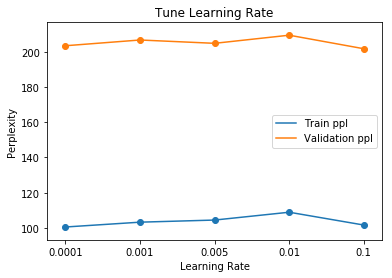

In [0]:
plt.plot(np.arange(5), ppl_ls, label='Train ppl')
plt.plot(np.arange(5), ppl_val_ls, label='Validation ppl')
plt.scatter(np.arange(5), ppl_ls)
plt.scatter(np.arange(5), ppl_val_ls)
plt.xticks(np.arange(5), lr_range)
plt.title('Tune Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Perplexity')
plt.legend()
plt.show()

Best learning rate = 0.1

Lowest validation perplexity = 201.7499

#### Tune number of layers

In [0]:
options = {'embedding_dim': 64,
           'hidden_size': 128,
           'input_size': 64,
           'num_embeddings': 33178,
           'num_layers': 2,
           'padding_idx': 2,
           'rnn_dropout': 0.1}

In [0]:
ppl_ls, ppl_val_ls = [], []
num_layers_range = [2, 3, 4]
for num_layers in num_layers_range:
    options['num_layers'] = num_layers
    ppl, ppl_val = TuneLSTM(options, learning_rate=0.1)
    ppl_ls.append(ppl)
    ppl_val_ls.append(ppl_val)

Avg train perplexity = 100.9032
Validation Perplexity = 201.2449

Avg train perplexity = 116.5239
Validation Perplexity = 214.9222

Avg train perplexity = 127.5283
Validation Perplexity = 229.9399



In [0]:
# num_layers_range = [2, 3, 4]
# ppl_ls = [100.9032, 116.5239, 127.5283]
# ppl_val_ls = [201.2449, 214.9222, 229.9399]

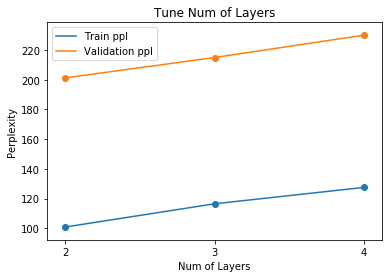

In [0]:
plt.plot(np.arange(3), ppl_ls, label='Train ppl')
plt.plot(np.arange(3), ppl_val_ls, label='Validation ppl')
plt.scatter(np.arange(3), ppl_ls)
plt.scatter(np.arange(3), ppl_val_ls)
plt.xticks(np.arange(3), num_layers_range)
plt.title('Tune Num of Layers')
plt.xlabel('Num of Layers')
plt.ylabel('Perplexity')
plt.legend()
plt.show()

Best Num_of_Layers = 2

Lowest validation perplexity = 201.2449

#### Tune embedding dimension

In [0]:
options = {'embedding_dim': 64,
           'hidden_size': 128,
           'input_size': 64,
           'num_embeddings': 33178,
           'num_layers': 2,
           'padding_idx': 2,
           'rnn_dropout': 0.1}

In [0]:
emb_list = [50, 64, 80, 128]
ppl_ls, ppl_val_ls = [], []
for emb_dim in emb_list:
    options['embedding_dim'] = emb_dim
    options['input_size'] = emb_dim
    ppl, ppl_val = TuneLSTM(options, learning_rate=0.1, epochs=10)
    ppl_ls.append(ppl)
    ppl_val_ls.append(ppl_val)

Avg train perplexity = 109.2812
Validation Perplexity = 210.4611

Avg train perplexity = 103.4594
Validation Perplexity = 206.3310

Avg train perplexity = 99.1214
Validation Perplexity = 204.2969

Avg train perplexity = 90.1317
Validation Perplexity = 198.0532



In [0]:
# emb_list = [50, 64, 80, 128]
# ppl_ls = [109.2812, 103.4594, 99.1214, 90.1317]
# ppl_val_ls = [210.4611, 206.3310, 204.2969, 198.0532]

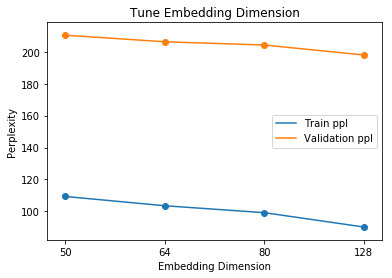

In [0]:
plt.plot(np.arange(4), ppl_ls, label='Train ppl')
plt.plot(np.arange(4), ppl_val_ls, label='Validation ppl')
plt.scatter(np.arange(4), ppl_ls)
plt.scatter(np.arange(4), ppl_val_ls)
plt.xticks(np.arange(4), emb_list)
plt.title('Tune Embedding Dimension')
plt.xlabel('Embedding Dimension')
plt.ylabel('Perplexity')
plt.legend()
plt.show()

Best embedding dimension = 128

Lowest validation perplexity = 198.0532

#### Results (LSTM vs. Baseline)

In [0]:
options = {'embedding_dim': 128,
           'hidden_size': 128,
           'input_size': 128,
           'num_embeddings': 33178,
           'num_layers': 2,
           'padding_idx': 2,
           'rnn_dropout': 0.1}

# ppl, ppl_val = TuneLSTM(options, learning_rate=0.1, save_model=True)

In [0]:
lstm = LSTMLanguageModel(options).to(current_device)
lstm.load_state_dict(torch.load('LSTM_best.ckpt'))
valid_losses = []
model.eval()
with torch.no_grad():
    for i, (inp, target) in enumerate(wiki_loaders['valid']):
        inp = inp.to(current_device)
        target = target.to(current_device)
        logits = lstm(inp)

        loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
        valid_losses.append(loss.item())
    avg_val_loss = sum(valid_losses) / len(valid_losses)
    ppl_val = 2**(avg_val_loss/np.log(2))
    print('Validation Perplexity = {:.{prec}f}'.format(ppl_val, prec=4))

Validation Perplexity = 199.6191


<font color='blue'>The lowest validation perplexity of LSTM model is around 199 after hyper-parameters tuning. Compared to RNN model, which had perplexity around 208, we got a slightly better performance.

### II.2 Learned Embeddings

#### Utilities

Below is code to use [UMAP](https://umap-learn.readthedocs.io/en/latest/) to find a 2-dimensional representation of a weight matrix, and plot the resulting 2-dimensional points that correspond to certain words.

Use `!pip install umap-learn` to install UMAP.

In [0]:
%pylab inline 
import umap
import matplotlib.pyplot as plt

def umap_plot(weight_matrix, word_ids, words):
    """Run UMAP on the entire Vxd `weight_matrix` (e.g. model.lookup.weight or model.projection.weight),
    And plot the points corresponding to the given `word_ids`. """
    reduced = umap.UMAP(min_dist=0.0001).fit_transform(weight_matrix.detach().cpu().numpy())
    plt.figure(figsize=(12,12))

    to_plot = reduced[word_ids, :]
    plt.scatter(to_plot[:, 0], to_plot[:, 1])
    for i, word_id in enumerate(word_ids):
        current_point = to_plot[i]
        plt.annotate(words[i], (current_point[0], current_point[1]))

    plt.grid()
    plt.show()

options = {'embedding_dim': 128,
           'hidden_size': 128,
           'input_size': 128,
           'num_embeddings': 33178,
           'num_layers': 2,
           'padding_idx': 2,
           'rnn_dropout': 0.1}

lstm = LSTMLanguageModel(options).to(current_device)
lstm.load_state_dict(torch.load('LSTM_best.ckpt'))

Populating the interactive namespace from numpy and matplotlib


#### II.2.1 Word Similarity

In [0]:
embed = lstm.lookup.to('cpu')
words = ['the', 'run', 'dog', 'where', 'quick']
ids = wiki_dict.encode_token_seq(words)
vecs = embed(torch.LongTensor(ids)).detach().numpy()
all_vecs = embed(torch.LongTensor(np.arange(len(wiki_dict)))).detach().numpy()
all_ids=[]
all_words=[]
for i in range(5):
    vec = vecs[i]
    cos_sim_ls = [sum(vec*v)/np.linalg.norm(vec)*np.linalg.norm(v) for v in all_vecs]
    sorted_cos_sim = np.sort(cos_sim_ls)
    closest, furthest = [], []
    for j in range(10):
      closest.append(int(np.where(cos_sim_ls==sorted_cos_sim[-j-2])[0]))
      furthest.append(int(np.where(cos_sim_ls==sorted_cos_sim[j])[0]))
    all_ids+=closest
    all_ids+=furthest
    print('10 cloeset words of "{}"'.format(words[i]))
    print(wiki_dict.decode_idx_seq(closest))
    all_words+=wiki_dict.decode_idx_seq(closest)
    print()
    print('10 furthest words of "{}"'.format(words[i]))
    print(wiki_dict.decode_idx_seq(furthest))
    all_words+=wiki_dict.decode_idx_seq(furthest)
    print()

10 cloeset words of "the"
['hydraulic', 'Mortal', 'your', 'each', 'Krak', 'Bir', 'Very', 'whose', 'Corpus', 'ample']

10 furthest words of "the"
['subjected', 'akin', 'attitudes', 'perception', 'conspiring', 'quantities', 'Tribute', 'need', 'convicts', 'Crazy']

10 cloeset words of "run"
['Due', 'motions', 'conversing', 'Relative', 'Ones', 'photograph', 'Cooksey', 'watch', 'improvements', 'until']

10 furthest words of "run"
['northerly', 'Reality', 'Armed', 'Bringin', 'circuits', 'carnival', 'extra', 'ramps', 'Bald', 'Tricky']

10 cloeset words of "dog"
['vibration', 'Sexton', 'dole', 'Quercus', 'Morning', 'Handel', 'consumers', 'secretly', 'kindly', 'Exclaim']

10 furthest words of "dog"
['[', 'Hazel', '@-@', 'cedar', 'del', 'Elijah', 'weeks', 'penetrating', 'Neotrygon', 'dean']

10 cloeset words of "where"
['Ramot', 'declare', '[', 'denying', 'when', 'why', 'From', 'whereby', 'transepts', 'whom']

10 furthest words of "where"
['closeness', 'Albums', 'midnight', 'distrust', 'directio

#### II.2.2 Embedding Layer

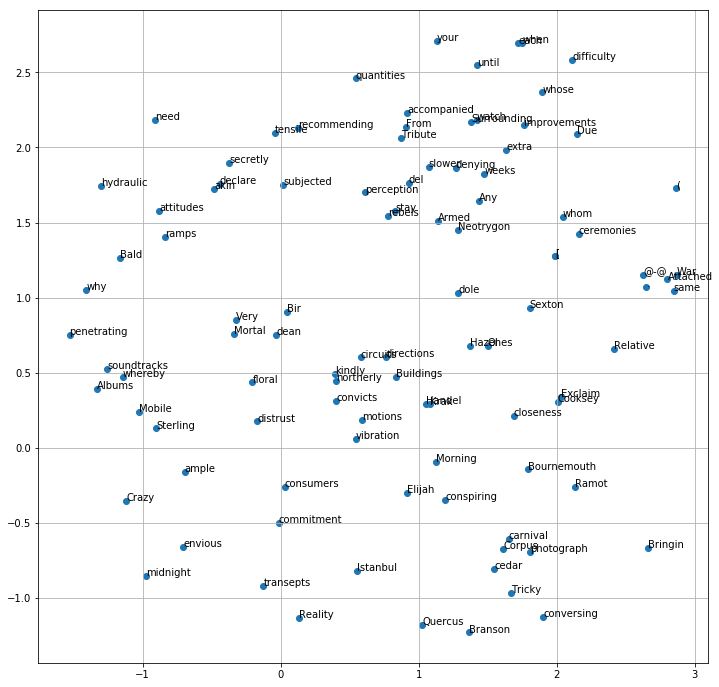

In [0]:
weight_matrix=embed(torch.LongTensor(np.arange(len(wiki_dict))))
umap_plot(weight_matrix, all_ids, all_words)

#### II.2.3 Projection Layer

In [0]:
words = ['the', 'run', 'dog', 'where', 'quick']
ids = wiki_dict.encode_token_seq(words)
layer = lstm.projection.weight.to('cpu').detach().numpy()
vecs = layer[ids,:]
all_vecs = layer
all_ids=[]
all_words=[]
for i in range(5):
    vec = vecs[i]
    cos_sim_ls = [sum(vec*v)/np.linalg.norm(vec)*np.linalg.norm(v) for v in all_vecs]
    sorted_cos_sim = np.sort(cos_sim_ls)
    closest, furthest = [], []
    for j in range(10):
      closest.append(int(np.where(cos_sim_ls==sorted_cos_sim[-j-2])[0]))
      furthest.append(int(np.where(cos_sim_ls==sorted_cos_sim[j])[0]))
    all_ids+=closest
    all_ids+=furthest
    print('10 cloeset words of "{}"'.format(words[i]))
    print(wiki_dict.decode_idx_seq(closest))
    all_words+=wiki_dict.decode_idx_seq(closest)
    print()
    print('10 furthest words of "{}"'.format(words[i]))
    print(wiki_dict.decode_idx_seq(furthest))
    all_words+=wiki_dict.decode_idx_seq(furthest)
    print()

10 cloeset words of "the"
['abbreviations', 'parole', 'treasonable', 'sway', 'Brodsky', 'Nol', 'Scapa', 'scrimmage', 'Hywel', 'changeable']

10 furthest words of "the"
['Powerful', 'Billa', "'Cruz", 'Habermas', 'Belaṭṭhaputta', 'Fantasies', 'Honors', 'Doux', "'aaknal", 'Margin']

10 cloeset words of "run"
['Kaiu', 'fledge', 'Freaks', 'tama', 'Thousand', 'Dionem', 'preclude', 'Belaṭṭhaputta', 'Sylvester', 'Luthor']

10 furthest words of "run"
['violacea', 'Crassweller', 'Meyers', 'Léon', 'Kash', 'Kinsey', 'Combs', 'Laureate', 'bernissartensis', 'Lawn']

10 cloeset words of "dog"
['tama', 'stylized', '497', 'stocked', 'staunch', 'shave', "'aaknal", 'Theroux', 'distracting', 'Version']

10 furthest words of "dog"
['<eos>', 'that', ',', '"', 'to', 'the', 'as', 'a', 'and', '<unk>']

10 cloeset words of "where"
['Kaiu', 'Interlude', 'whatsoever', 'liable', 'Hurt', 'Gryposaurus', 'Sửu', 'Adi', 'clearances', 'og']

10 furthest words of "where"
['intestinal', 'insertion', 'dissatisfaction', 'fo

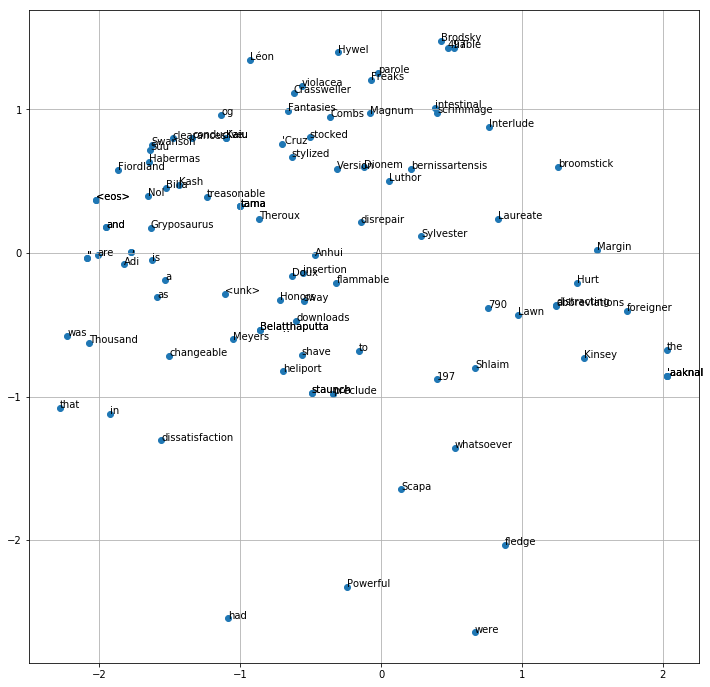

In [0]:
weight_matrix=embed(torch.LongTensor(np.arange(len(wiki_dict))))
umap_plot(weight_matrix, all_ids, all_words)

<font color='blue'>
The "closest" and "furthest" words generated by our model do not really make sense in a normal narrative way. The projection layer visualizations is more centerd while the embedding visualizations is more spread.

### II.3 Scoring

#### II.3.1 Implement score function 

In [0]:
import math

def score(sentence, model):
    x = sentence[:-1]
    y = sentence[1:]

    pred = model(torch.LongTensor(x).to(current_device).view(1,-1))
    prob = nn.Softmax(dim=1)(pred[0])
    #prob = prob.view(prob.size(1), prob.size(2))

    log_p = 0
    for i in range(len(y)):
        log_p += math.log2(prob[i, y[i]])

    return log_p

#### II.3.2 Highest and Lowest scoring sequences

In [0]:
options = {'embedding_dim': 128,
           'hidden_size': 128,
           'input_size': 128,
           'num_embeddings': 33178,
           'num_layers': 2,
           'padding_idx': 2,
           'rnn_dropout': 0.1}

lstm = LSTMLanguageModel(options).to(current_device)
lstm.load_state_dict(torch.load('LSTM_best.ckpt'))

In [0]:
valid_data = datasets['valid']
scores = []
for  sentence in valid_data:
    sentence = wiki_dict.encode_token_seq(sentence)
    scores.append(score(sentence,lstm))

In [0]:
sorted_scores = np.sort(scores)
highest = []
lowest = []
for i in range(10):
    highest.append(valid_data[int(np.where(scores==sorted_scores[-i-1])[0])])
    lowest.append(valid_data[int(np.where(scores==sorted_scores[i])[0])])

In [0]:
high_sen, low_sen = [], []
for i in range(10):
  high_sen.append(" ".join(highest[i]))
  low_sen.append(" ".join(lowest[i]))

In [89]:
high_sen

['= = Culture and the arts = =',
 '= = = <unk> from the stage = = =',
 'Calvin <unk> ( born November 2 , 1984 )',
 'The trial started on February 4 , 2013 .',
 '( <unk> ) with winds of 35 mph ( 55 km / h ) .',
 'This project was completed on June 18 , 2010 .',
 '<unk> from the original on October 2 , 2006 .',
 '= = Return to New Zealand = =',
 '= = Post @-@ war period = =',
 '= = <unk> spin @-@ off = =']

In [90]:
low_sen

["Two rival communist @-@ backed black nationalist groups initiated military campaigns to overthrow the government and introduce majority rule : the Chinese @-@ aligned Zimbabwe African National Union ( <unk> ) , mostly comprising <unk> , created the Zimbabwe African National Liberation Army ( ZANLA ) and adopted aspects of <unk> doctrine , while the <unk> @-@ dominated Zimbabwe African People 's Union ( <unk> ) , aligned with Soviet @-@ style <unk> – <unk> and the Warsaw Pact , mobilised the Zimbabwe People 's Revolutionary Army ( <unk> ) .",
 'To further justify its stance , the German government has also pointed to the long history of U.S. court cases involving Scientology , including the conviction of 11 top Scientologists in 1979 and 1980 for a conspiracy involving the infiltration of U.S. government agencies , <unk> and the theft of government documents , a 1994 U.S. Supreme Court finding that Scientology practices took place in a " <unk> environment " , and Scientology \'s track

#### II.3.3 Modified sequences

In [140]:
sen = highest[0].copy()
original = wiki_dict.encode_token_seq(sen)
sen[2], sen[3] = 'Return', 'to'
modified = wiki_dict.encode_token_seq(sen)
print("Original sentence is:  '{}'".format(" ".join(highest[0])))
print("Score for original sentence: {}".format(score(original, lstm)))
print()
print("Modified sentence is:  '{}'".format(" ".join(sen)))
print("Score for modified sentence: {}".format(score(modified, lstm)))


Original sentence is:  '= = Culture and the arts = ='
Score for original sentence: -43.74724913531284

Modified sentence is:  '= = Return to the arts = ='
Score for modified sentence: -42.689607458264156


<font color='blue'>
The score increases if we change "Culture and" to "Return to". The reason may be that "Return to" occurs more frequently than "Culture to". 

In [141]:
sen = highest[0].copy()
original = wiki_dict.encode_token_seq(sen)
sen[5] = 'stage'
modified = wiki_dict.encode_token_seq(sen)
print("Original sentence is:  '{}'".format(" ".join(highest[0])))
print("Score for original sentence: {}".format(score(original, lstm)))
print()
print("Modified sentence is:  '{}'".format(" ".join(sen)))
print("Score for modified sentence: {}".format(score(modified, lstm)))


Original sentence is:  '= = Culture and the arts = ='
Score for original sentence: -43.74724913531284

Modified sentence is:  '= = Culture and the stage = ='
Score for modified sentence: -48.63017949405471


<font color='blue'>
  The score decreases if we change "arts" to "stage". Because "arts" is often used together with "culture" but "stage" not.

### II.4 Sampling

#### II.4.1 Implement sampling

In [0]:
def pred_next_word(model, word, hidden):
    embed = model.lookup(word)
    if not hidden:
        out, h = model.lstm(embed)
    else:
        out, h = model.lstm(embed, hidden)
    out = model.projection(out)
    
    prob = nn.Softmax(dim=2)(out)
    pred = torch.multinomial(prob.view(-1), 1)
    
    return pred, h

  
def sample_sentence(model, size, start_word):
    samples=[]
    end=wiki_dict.get_id('<eos>')

    for i in range(size):
        word = torch.LongTensor([[wiki_dict.get_id(start_word)]]).to(current_device)
        hidden = None
        sentence = [word]    
        while sentence[-1] != end:
            word, hidden = pred_next_word(model, word.view(-1,1), hidden)
            sentence.append(word)

        sentence = wiki_dict.decode_idx_seq(sentence[1:-1])
        samples.append(sentence)
    
    return samples

#### II.4.2 Sample 1000 sequences from the best LSTM model

In [0]:
lstm = LSTMLanguageModel(options).to(current_device)
lstm.load_state_dict(torch.load('LSTM_best.ckpt'))

samples = sample_sentence(lstm, 1000, '<bos>')

In [142]:
samples[0]

['As',
 'Amanita',
 'ideas',
 'working',
 'in',
 'Cook',
 "'s",
 'doctor',
 ',',
 'McCartney',
 'easily',
 'notes',
 'guests',
 'from',
 'some',
 'religious',
 'generals',
 'having',
 'initially',
 'occasionally',
 'defeats',
 'passengers',
 '.']

#### II.4.3 Number of unique tokens and sequence length 

(1,000 samples vs. 1,000 randomly selected validation-set sequences)

In [99]:
valid_samples = random.sample(valid_data, 1000)
valid_tokens = []
for sen in valid_samples:
    valid_tokens += sen
    
print("Number of unique tokens in validation samples: {}".format(len(set(valid_tokens))))
print("Average length of sentences in validation samples: {}".format(len(valid_tokens)/1000))

Number of unique tokens in validation samples: 4969
Average length of sentences in validation samples: 22.905


In [100]:
sampling = []
for sen in samples:
    sampling += sen
    
print("Number of unique tokens in generated sentences: {}".format(len(set(sampling))))
print("Average length of sentences in generated sentences: {}".format(len(sampling)/1000))

Number of unique tokens in generated sentences: 5836
Average length of sentences in generated sentences: 22.601


#### II.4.4 Example Samples

In [101]:
generated_sen = []
for i in range(1000):
    generated_sen.append(" ".join(samples[i]))

random.sample(generated_sen, 3)

['The reduction of condom may be constructed for the relative amino acids at the ramps and kept incendiary assistance from a serious green <unk> .',
 '> and his Marquess of the final years , used to stimulate business in Ireland and slavery in the ninth decades as he who took their first government against the shot .',
 "Shiban also called Carey 's true hero , announcing for prostitutes about taking his relationship with his previous son , Ron Preston , compositions ."]

<font color='blue'>
  Those generated sentences are mostly correct in its grammar and the correct use of capital words and punctuation. However, we can still tell they are model-generated rather than human-generated since they sometimes do not stay in topic and appear some <unk>/“>” symbols.